In [1]:
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import copy
import os
import time
import seaborn as sns
import operator
import ray

from sklearn.preprocessing import LabelEncoder
from scipy.stats import variation
from operator import itemgetter
from collections import Counter

/data/home/dag8523/mdt/env/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
class solution:
    def __init__(self, variables, objective_functions, objective_goals):
        self.variables = variables
        self.objectives = [function(self.variables) for function in objective_functions]
        self.objective_goals = objective_goals
        self.crowding_distance = None
        self.hops_frequency = None
        
    def users_in_same_team(self, searched_members):
        n_times = 0
        for t in self.variables:
            if all(np.isin(searched_members, t)):
                n_times += 1
        return n_times
    
    # Check team's hop frequency
    def set_hops_frequency(self, G):
        self.hops_frequency = {}
        for k, g in enumerate(self.variables):
            self.hops_frequency[k] = {0:0,1:0}
            for u in g:
                for v in g:
                    if nx.algorithms.shortest_paths.generic.has_path(G, source=u, target=v):
                        hops = nx.shortest_path_length(G, source=u, target=v)
                        if hops in self.hops_frequency[k]:
                            self.hops_frequency[k][hops] += 1
                        else:
                            self.hops_frequency[k][hops] = 1
                    else:
                        self.hops_frequency[k][0] += 1

def dominates(sol_1, sol_2, objective_functions_dimensions):
    and_condition = True
    or_condition = False

    for i in range(objective_functions_dimensions):
        if sol_2.objective_goals[i] == 'MIN':
            and_condition = and_condition and sol_1.objectives[i] <= sol_2.objectives[i]
            or_condition = or_condition or sol_1.objectives[i] < sol_2.objectives[i]
        elif sol_2.objective_goals[i] == 'MAX':
            and_condition = and_condition and sol_1.objectives[i] >= sol_2.objectives[i]
            or_condition = or_condition or sol_1.objectives[i] > sol_2.objectives[i]

    return (and_condition and or_condition)

def cost(sol_1, sol_2, objective_functions_dimensions):
    and_condition = True

    for i in range(objective_functions_dimensions):
        if sol_2.objective_goals[i] == 'MIN':
            and_condition = and_condition and sol_1.objectives[i] <= sol_2.objectives[i]
        elif sol_2.objective_goals[i] == 'MAX':
            and_condition = and_condition and sol_1.objectives[i] >= sol_2.objectives[i]

    return and_condition

def lower(sol_1, sol_2, objective_functions_dimensions):
    and_condition = True

    for i in range(objective_functions_dimensions):
        if sol_2.objective_goals[i] == 'MIN':
            and_condition = and_condition and sol_1.objectives[i] < sol_2.objectives[i]
        elif sol_2.objective_goals[i] == 'MAX':
            and_condition = and_condition and sol_1.objectives[i] > sol_2.objectives[i]

    return and_condition

# Define Blau Index
def blau(x):
    return 1-(sum([(float(n)/len(x))*(float(n)/len(x)) for n in np.bincount(x.astype(int))]))

## Check that teams were created correctly
def check_population(population):
    members = []

    # Extract all members
    for team in population[0].variables:
        members.extend(team)

    # Length of unique members
    print("Unique members: "+ str(len(list(set(members)))))

    # Get the total length
    print("Total members: " + str(len(members)))

    # Print teams
    #display(population[0].variables)

In [3]:
"""
    Code Taken from 
    https://github.com/DEAP/deap/blob/b8513fc16fa05b2fe6b740488114a7f0c5a1dd06/deap/tools/_hypervolume/pyhv.py#L322
        
    Modified by Bradley Pawlow
"""
# # Hypervolume Indicator 
def hypervolume(population, ref):
    hv = _HyperVolume(ref)

    ## Converting Population of solutions into right format for HyperVolume Indicator 
    pointset = []

    for sol in population: 
        temp = copy.deepcopy(sol)
        for k, o in enumerate(temp.objectives):
            if temp.objective_goals[k] == "MAX":
                temp.objectives[k] = temp.objectives[k] * -1
        pointset.append(tuple(temp.objectives))

    return hv.compute(pointset)

class _HyperVolume:
    def __init__(self, referencePoint):
        self.referencePoint = referencePoint
        self.list = []

    def compute(self, front):
        """Returns the hypervolume that is dominated by a non-dominated front.
        Before the HV computation, front and reference point are translated, so
        that the reference point is [0, ..., 0].
        """

        referencePoint = self.referencePoint
        dimensions = len(referencePoint)
        relevantPoints = front

        # fmder
        #######
        if any(referencePoint):
            relevantPoints -= referencePoint

        self.preProcess(relevantPoints)
        bounds = [-1.0e308] * dimensions
        hyperVolume = self.hvRecursive(dimensions - 1, len(relevantPoints), bounds)
        return hyperVolume


    def hvRecursive(self, dimIndex, length, bounds):
        """Recursive call to hypervolume calculation.
        In contrast to the paper, the code assumes that the reference point
        is [0, ..., 0]. This allows the avoidance of a few operations.
        """
        hvol = 0.0
        sentinel = self.list.sentinel
        if length == 0:
            return hvol
        elif dimIndex == 0:
           # special case: only one dimension
           # why using hypervolume at all?
            return -sentinel.next[0].cargo[0]
        elif dimIndex == 1:
            # special case: two dimensions, end recursion
            q = sentinel.next[1]
            h = q.cargo[0]
            p = q.next[1]
            while p is not sentinel:
                pCargo = p.cargo
                hvol += h * (q.cargo[1] - pCargo[1])
                if pCargo[0] < h:
                    h = pCargo[0]
                q = p
                p = q.next[1]
            hvol += h * q.cargo[1]
            return hvol
        else:
            remove = self.list.remove
            reinsert = self.list.reinsert
            hvRecursive = self.hvRecursive
            p = sentinel
            q = p.prev[dimIndex]
            while q.cargo != None:
                if q.ignore < dimIndex:
                    q.ignore = 0
                q = q.prev[dimIndex]
            q = p.prev[dimIndex]
            while length > 1 and (q.cargo[dimIndex] > bounds[dimIndex] or q.prev[dimIndex].cargo[dimIndex] >= bounds[dimIndex]):
                p = q
                remove(p, dimIndex, bounds)
                q = p.prev[dimIndex]
                length -= 1
            qArea = q.area
            qCargo = q.cargo
            qPrevDimIndex = q.prev[dimIndex]
            if length > 1:
                hvol = qPrevDimIndex.volume[dimIndex] + qPrevDimIndex.area[dimIndex] * (qCargo[dimIndex] - qPrevDimIndex.cargo[dimIndex])
            else:
                qArea[0] = 1
                qArea[1:dimIndex+1] = [qArea[i] * -qCargo[i] for i in range(dimIndex)]
            q.volume[dimIndex] = hvol
            if q.ignore >= dimIndex:
                qArea[dimIndex] = qPrevDimIndex.area[dimIndex]
            else:
                qArea[dimIndex] = hvRecursive(dimIndex - 1, length, bounds)
                if qArea[dimIndex] <= qPrevDimIndex.area[dimIndex]:
                    q.ignore = dimIndex
            while p is not sentinel:
                pCargoDimIndex = p.cargo[dimIndex]
                hvol += q.area[dimIndex] * (pCargoDimIndex - q.cargo[dimIndex])
                bounds[dimIndex] = pCargoDimIndex
                reinsert(p, dimIndex, bounds)
                length += 1
                q = p
                p = p.next[dimIndex]
                q.volume[dimIndex] = hvol
                if q.ignore >= dimIndex:
                    q.area[dimIndex] = q.prev[dimIndex].area[dimIndex]
                else:
                    q.area[dimIndex] = hvRecursive(dimIndex - 1, length, bounds)
                    if q.area[dimIndex] <= q.prev[dimIndex].area[dimIndex]:
                        q.ignore = dimIndex
            hvol -= q.area[dimIndex] * q.cargo[dimIndex]
            return hvol

    def preProcess(self, front):
        """Sets up the list data structure needed for calculation."""
        dimensions = len(self.referencePoint)
        nodeList = _MultiList(dimensions)
        nodes = [_MultiList.Node(dimensions, point) for point in front]
        for i in range(dimensions):
            self.sortByDimension(nodes, i)
            nodeList.extend(nodes, i)
        self.list = nodeList


    def sortByDimension(self, nodes, i):
        """Sorts the list of nodes by the i-th value of the contained points."""
        # build a list of tuples of (point[i], node)
        decorated = [(node.cargo[i], node) for node in nodes]
        # sort by this value
        decorated.sort()
        # write back to original list
        nodes[:] = [node for (_, node) in decorated]

class _MultiList: 
    """A special data structure needed by FonsecaHyperVolume. 
    It consists of several doubly linked lists that share common nodes. So, 
    every node has multiple predecessors and successors, one in every list.
    """

    class Node: 
        def __init__(self, numberLists, cargo=None): 
            self.cargo = cargo 
            self.next  = [None] * numberLists
            self.prev = [None] * numberLists
            self.ignore = 0
            self.area = [0.0] * numberLists
            self.volume = [0.0] * numberLists
        def __str__(self): 
            return str(self.cargo)
        def __lt__(self, other):
            return all(self.cargo < other.cargo)

    def __init__(self, numberLists):  
        """Constructor. 
        Builds 'numberLists' doubly linked lists.
        """
        self.numberLists = numberLists
        self.sentinel = _MultiList.Node(numberLists)
        self.sentinel.next = [self.sentinel] * numberLists
        self.sentinel.prev = [self.sentinel] * numberLists

    def __str__(self):
        strings = []
        for i in range(self.numberLists):
            currentList = []
            node = self.sentinel.next[i]
            while node != self.sentinel:
                currentList.append(str(node))
                node = node.next[i]
            strings.append(str(currentList))
        stringRepr = ""
        for string in strings:
            stringRepr += string + "\n"
        return stringRepr

    def __len__(self):
        """Returns the number of lists that are included in this _MultiList."""
        return self.numberLists

    def getLength(self, i):
        """Returns the length of the i-th list."""
        length = 0
        sentinel = self.sentinel
        node = sentinel.next[i]
        while node != sentinel:
            length += 1
            node = node.next[i]
        return length

    def append(self, node, index):
        """Appends a node to the end of the list at the given index."""
        lastButOne = self.sentinel.prev[index]
        node.next[index] = self.sentinel
        node.prev[index] = lastButOne
        # set the last element as the new one
        self.sentinel.prev[index] = node
        lastButOne.next[index] = node

    def extend(self, nodes, index):
        """Extends the list at the given index with the nodes."""
        sentinel = self.sentinel
        for node in nodes:
            lastButOne = sentinel.prev[index]
            node.next[index] = sentinel
            node.prev[index] = lastButOne
            # set the last element as the new one
            sentinel.prev[index] = node
            lastButOne.next[index] = node

    def remove(self, node, index, bounds): 
        """Removes and returns 'node' from all lists in [0, 'index'[."""
        for i in range(index): 
            predecessor = node.prev[i]
            successor = node.next[i]
            predecessor.next[i] = successor
            successor.prev[i] = predecessor  
            if bounds[i] > node.cargo[i]:
                bounds[i] = node.cargo[i]
        return node

    def reinsert(self, node, index, bounds):
        """
        Inserts 'node' at the position it had in all lists in [0, 'index'[
        before it was removed. This method assumes that the next and previous 
        nodes of the node that is reinserted are in the list.
        """
        for i in range(index):
            node.prev[i].next[i] = node
            node.next[i].prev[i] = node
            if bounds[i] > node.cargo[i]:
                bounds[i] = node.cargo[i]

# # Non-dominated Front Size Indicator
def non_dominated_fs(solutions, names): 
    all_solutions = []

    # Combine all solutions together as part of preprocessing 
    for i in range(len(solutions)):
        for sol_point in solutions[i]:
            temp = []
            for obj in sol_point.objectives:
                temp.append(obj)
            temp.append(names[i])
            all_solutions.append(temp)

    # Sort solutions by lowest to highest communication cost 
    all_solutions = sorted(all_solutions, key=lambda x:x[0])

    # Find nondominating solutions
    non_dom_sol = []
    for j in range(len(all_solutions)):
        if not non_dom_sol: 
            non_dom_sol.append(all_solutions[j])
            continue
        else:
            if all_solutions[j][1] > non_dom_sol[0][1]:
                non_dom_sol.append(all_solutions[j])
        non_dom_sol = sorted(non_dom_sol, key=lambda x:x[1], reverse = True)

    # Calculate ratio of different algos to total nondominated solutions
    algo_list = []

    for k in non_dom_sol: 
        algo_list.append(k[2])

    count = dict(Counter(algo_list))

    for key in count: 
        count[key] = count[key] / len(non_dom_sol)

    # Add 0 solution point algorithms to dictionary
    for var in names: 
        if var in count:
            continue
        else: 
            count[var] = 0
    count = dict( sorted(count.items(), key=operator.itemgetter(1),reverse=True))

    return count

In [4]:
@ray.remote
def create_teams(database_name, users_file, relationships_file, num_skills, team_size, input_size = None, 
                 demographics = False, ref_x = 2000, ref_y = 200, population_size = 50, 
                 archive_size = 50, max_gen = 50, max_pls_gen = 1):
    # Time
    times = {}

    # Import Data
    users = pd.read_csv(users_file)
    relationships = pd.read_csv(relationships_file)

    # Fix age
    if demographics:
        # Fix age
        users['age'].fillna(18,inplace=True)

        # Fix ids
        users = users.astype({'age':int})
    else:
        # Change user's column name
        users.rename(columns={users.columns[0]: "user_id"}, inplace=True)
    
    # Fix ids
    users = users.astype({'user_id':str})

    # Remove duplicate users
    users = users.drop_duplicates(subset=['user_id'])

    # If there is a specific input size, create a sample
    if ~np.isnan(input_size):
        
        # Check the total size and return None if it's bigger
        if input_size > len(users):
            return None
        
        # Select a sample
        users = users.sample(input_size)
        relationships = relationships[(relationships.source.isin(users.user_id)) & 
                                      (relationships.target.isin(users.user_id))]
    
    # Define number of teams
    n_participants = len(users)
    n_teams = int(n_participants/team_size)
    remainder = n_participants % team_size

    # Create array to teams of size "team_size" and one team of size "remainder"
    team_divisions = list(range(team_size,n_participants,team_size))

    # Create a separated team with the remainder
    np.array_split(np.zeros(n_participants), team_divisions)

    # Update the total number of teams
    n_teams = len(np.array_split(np.zeros(n_participants), team_divisions))

    # Create social network
    G = nx.Graph()
    G.add_nodes_from(users['user_id'])

    for index, k in relationships.iterrows():
        G.add_edge(k['source'], k['target'])

    # Plot network
    #nx.draw(G, pos=nx.spring_layout(G))
    #plt.show()
    #plt.clf()

    # Check if it's fully connected and define diameter
    diameter = 0
    if not nx.is_connected(G):
        for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
            diameter = max(nx.diameter(C), diameter)
    else:
        diameter = nx.diameter(G)
        
    # Check for isolates
    isolates = list(nx.isolates(G))
    
    # Check for the number of components
    components = nx.connected_components(G)
    nx.algorithms.components.number_connected_components(G)

    # # Diversity analysis
    # create profile vectors for diversity measure 
    usrvectors = {}
    for index, u in users.iterrows():
        id = u.user_id
        
        try:
            skill = u['skill.1':'skill.'+str(num_skills)]
        except:
            print("invalid number of skills")

        if demographics:
            if u.gender == 'M':
                gender = 0
            else:
                gender = 1
            try:
                age = u.age
            except:
                age = 24
            try:
                international = u.international
                if np.isnan(international):
                    international = 0
            except:
                international = 0

            # Create vector
            usrvectors.update({str(id) : [np.concatenate((np.array([gender, age, international]), skill.fillna(0)))]})
        else:
            usrvectors.update({str(id) : [np.concatenate((np.array([0]), skill))]})

    # # Problem formulation
    # Communication cost:
    # Diameter version
    def communication_cost(variables=[0]):
        H = nx.Graph()
        H.add_nodes_from(list(itertools.chain.from_iterable(variables)))
        for g in variables:
            for u in g:
                for v in g:
                    if G.has_edge(u,v):
                        H.add_edge(u, v)
        H0 = [H.subgraph(c).copy() for c in nx.connected_components(H)]
        d = 0
        for h in H0:
            if h.number_of_nodes() > 1:
                d += nx.algorithms.distance_measures.diameter(h)
            else:
                d += diameter
        return d

    # Diversity index
    def diversity_index(variables=[0]):
        sum_sum = 0
        for g in variables:
            if demographics:
                #age
                sum_sum += variation(np.array([usrvectors[i][0][1] for i in g]))
                #gender
                sum_sum += blau(np.array([usrvectors[i][0][0] for i in g]))
                #international
                sum_sum += blau(np.array([usrvectors[i][0][2] for i in g]))
                # skills
                for k in range(3, 3 + num_skills):
                    values = np.array([usrvectors[i][0][k] for i in g])
                    if sum(values):
                        sum_sum += variation(values)
            else:
                # skills
                for k in range(1,1 + num_skills):
                    values = np.array([usrvectors[i][0][k] for i in g])
                    if sum(values):
                        sum_sum += variation(values)

        return sum_sum

    objective_functions = [communication_cost, diversity_index]
    objective_goals = ['MIN','MAX']
    objective_functions_dimensions = len(objective_functions)
    length = population_size + archive_size

    def create_real_teams(people):
        people_in_teams = people.dropna()
        missing_people = list(set(people.user_id) - set(people_in_teams.user_id))
        people = people.dropna()

        # Identifying teams ids
        teams = []
        teams_list = people.groupby('team_id').size()
        teams_ids = list(set(people.team_id))

        # Check teams of size 1
        for t in teams_ids:
            members = people[people.team_id == t]['user_id']
            if len(members) == 1 or len(members) <= team_size / 2:
                for m in members:
                    missing_people.append(m)
                teams_ids.remove(t)

        # Creating teams
        for t in teams_ids:
            members = people[people.team_id == t]['user_id']
            k = team_size - len(members)

            if k > 0 and len(missing_people) >= k:
                new_members = random.sample(missing_people, k)
                for m in new_members:
                    missing_people.remove(m)
                teams.append(np.concatenate((np.array(members),new_members)))
            else:
                teams.append(np.array(members))

        # If there are members missing
        while len(missing_people) >= team_size:
            new_members = random.sample(missing_people, team_size)
            teams.append(np.array(new_members))
            for m in new_members:
                missing_people.remove(m)

        # Create a last team
        if len(missing_people) > 1:
            teams.append(np.array(missing_people))

        # Add teams to the population
        population = [solution(teams, objective_functions, objective_goals)]

        return population

    def create_random_teams(people):
        # Start counting
        start = time.time()

        # Initialization
        pop = list(people)
        population = []

        # Create population
        for i in range(population_size):
            random.shuffle(pop)
            population.append(solution(np.array_split(np.array(pop), team_divisions), objective_functions, objective_goals))

        # End time
        end = time.time()

        # Add the timers
        times['random'] = {'start': start, 'end': end, "diff": end - start}

        return population


    # # NSGA-II Implementation
    def crossover(p1, p2):
        try:
            # Combine both parents and select teams randomly 
            group_pool = [list(x) for x in p1] + [list(x) for x in p2] 

            # Check if we need to split differently 
            if remainder > 0:
                # Identify the teams of size 'team_size'
                teams_correct_size = [t for t in group_pool if len(t) == team_size]

                # Identify the teams of size 'remainder'
                teams_remainder_size = [t for t in group_pool if len(t) == remainder]

                # Check that we have all the teams
                if len(teams_correct_size) + len(teams_remainder_size) != 2 * (n_teams):
                    raise Exception("NSGA-II: Teams don't match")

                # Select teams of size 'team_size'
                child = random.sample(teams_correct_size, n_teams - 1)
                child = child + random.sample(teams_remainder_size, 1)
            else:
                child = random.sample(group_pool, n_teams)

            # Check missing members 
            child = list(itertools.chain.from_iterable(child))
            missing_members = list(set(users['user_id']) - set(child))
            count = []

            # Replace duplicated items with missing members
            for i in range(len(child)):
                if child[i] in count:
                    member = random.choice(missing_members)
                    child[i] = member
                    missing_members.remove(member)
                else:
                    count.append(child[i])

            # Split
            child = [child[i:i + team_size] for i in range(0, len(child), team_size)] 

            # Assign
            return(child)
        except Exception as inst:
            print("something is wrong")
            print(inst)

    def generate_offspring(population):
        new_population = []

        for i in range(population_size):
            a1 = random.randint(0,population_size-1)
            b1 = random.randint(0,population_size-1)

            # Create chromosomes
            p1 = population[a1].variables
            p2 = population[b1].variables

            # Create the solution
            child = solution(crossover(p1,p2), objective_functions, objective_goals)

            # Append the solution
            new_population.append(child)

        return new_population

    # Function to carry out NSGA-II's fast non dominated sort
    def fast_non_dominated_sort(population):
        fronts = [[]]
        domination_count = np.zeros(len(population))
        dominated_solutions = [[] for i in range(len(population))]
        rank = np.zeros(len(population))

        # Check whether a solution dominates all the other solutions
        for i, solution1 in enumerate(population):
            for j, solution2 in enumerate(population):
                if dominates(solution1, solution2, objective_functions_dimensions):
                    dominated_solutions[i].append(j)
                elif dominates(solution2, solution1, objective_functions_dimensions):
                    domination_count[i] += 1
            if domination_count[i] == 0:
                # If solution 1 dominates all the others, we put it in the first Pareto front
                rank[i] = 0
                fronts[0].append(i)

        # We create the Pareto fronts checking how many times they dominate other solutions
        k = 0
        while len(fronts[k]) > 0:
            temp = []
            for i in fronts[k]:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        # If solution J dominates all the others, we add it to the current Pareto front.
                        rank[j] = k + 1
                        temp.append(j)
            k += 1    
            fronts.append(temp)

        # Remove the empty array
        del fronts[len(fronts)-1]

        # Replace the indices with the solutions
        for k in range(len(fronts)):
            fronts[k] = [population[i] for i in fronts[k]]

        return fronts


    def calculate_crowding_distance(front):
        if len(front) > 0:
            # Define 0 for each solution's crowding distance
            for individual in front:
                individual.crowding_distance = 0

            for i in range(objective_functions_dimensions):
                # See how the solutions must be sorted
                reverse = False
                if objective_goals[i] == 'MAX': reverse = True

                # Sort the front according to its objective value
                front.sort(key=lambda solution: solution.objectives[i], reverse = reverse)

                # Establish distances between the extremes
                front[0].crowding_distance = 10**9
                front[len(front) - 1].crowding_distance = 10**9

                # Get the values
                values = [individual.objectives[i] for individual in front]

                # Scale the data if it's possible
                scale = max(values) - min(values)
                if scale == 0: scale = 1

                # Calculate distance
                for k in range(1,len(front)-1):
                    front[k].crowding_distance += (front[k+1].objectives[i] - front[k-1].objectives[i])/scale

    def create_nsga2_teams(people, initial_population = None):
        # NSGA-II Implementation
        try:
            # End time
            start = time.time()

            #Initialization
            pop = list(people)
            population = []
            gen_no=1                          

            # Sort until we achieve the number of iterations
            while(gen_no < max_gen):
                #print("Generation ",gen_no)

                # Creating the population
                if initial_population:
                    population = initial_population
                elif gen_no == 1:
                    # Create population
                    for i in range(population_size):
                        random.shuffle(pop)
                        population.append(solution(np.array_split(np.array(pop), team_divisions), objective_functions, objective_goals))

                # Generate offspring
                children = generate_offspring(population)

                # Merge the population and its children
                population.extend(children)

                # Perform non dominated sort
                fronts = fast_non_dominated_sort(population) 

                # Create new population
                new_population = []

                # Calculate the crowding distance
                front_num = 0

                # Add fronts until we have the allow number
                while len(new_population) + len(fronts[front_num]) <= population_size:
                    calculate_crowding_distance(fronts[front_num])
                    #fronts[front_num].sort(key=lambda individual: individual.crowding_distance, reverse=True)
                    new_population.extend(fronts[front_num])
                    front_num += 1

                # Perform another crowding distance
                calculate_crowding_distance(fronts[front_num])

                # Sort front's solutions according to their crowding distance
                fronts[front_num].sort(key=lambda individual: individual.crowding_distance, reverse=True)

                # Add final teams
                new_population.extend(fronts[front_num][0:population_size-len(new_population)])

                # Select the Pareto front for the next generation
                population = new_population

                # We increase the size
                gen_no = gen_no + 1

            # End time
            end = time.time()

            # Add the timers
            times['nsga2'] = {'start': start, 'end': end, "diff": end - start}

            return population
        except Exception as inst:
            print('An exception flew by!')
            raise

    def dominated_by(sol_1, sol_2):
        for i in range(objective_functions_dimensions):
            if sol_2.objective_goals[i] == 'MIN' and sol_2.objectives[i] > sol_1.objectives[i]:
                return False
            elif sol_2.objective_goals[i] == 'MAX' and sol_2.objectives[i] < sol_1.objectives[i]:
                return False
        return True

    def calculate_raw_fitness(population):
        strength = np.zeros(length)
        raw_fitness = np.zeros(length)
        dominations = {}
        for i in range(length):
            dominations[i] = []
            for j in range(length):
                if i != j:
                    if not dominated_by(population[i], population[j]):
                        strength[i] = strength[i] + 1
                    else:
                        dominations[i].append(j)
        for i in range(length):
            for j in dominations[i]:
                raw_fitness[i] = raw_fitness[i] + strength[j]
        return raw_fitness

    def trim_archive(archive, fitness):
        while len(archive) > archive_size:
            all_distances = []
            for i in range(len(archive)):
                distances = []
                for j in range(len(archive)):
                    if i != j:
                        sol_1 = archive[i]
                        sol_2 = archive[j]
                        distance = sum([(sol_1.objectives[i] - sol_2.objectives[i])**2 for i in range(objective_functions_dimensions)])
                        distances.append(distance)
                distances.sort()
                all_distances.append(distances)
            k_n = 1
            while True: 
                closest_n = min(all_distances[i][k_n] for i in range(len(all_distances)))
                most_crowded = [i for i in range(len(all_distances)) if all_distances[i][k_n] == closest_n]
                if len(most_crowded) == 1: 
                    archive.pop(most_crowded[0])
                    fitness.pop(most_crowded[0])
                    break
                else:
                    k_n = k_n + 1
        return archive, fitness

    def sort_population(population, fitness):
        sorted_ids = np.argsort(fitness)
        new_fitness = [fitness[sorted_ids[i]] for i in range(length)]
        new_population = [population[sorted_ids[i]] for i in range(length)]
        return new_population, new_fitness

    def crossover_spea(solution):
        try:
            # Check if we need to split differently 
            if remainder > 0:
                # Identify the teams of size 'team_size'
                teams_correct_size = [t for t in solution.variables if len(t) == team_size]

                # Identify the teams of size 'remainder'
                teams_remainder_size = [t for t in solution.variables if len(t) == remainder]

                # Check that we have all the teams
                if len(teams_correct_size) + len(teams_remainder_size) != (n_teams):
                    raise Exception("SPEA-2: Teams don't match")

                # Select teams of size 'team_size'
                child = random.sample(teams_correct_size, n_teams - 1)
                child = child + random.sample(teams_remainder_size, 1)
            else:
                child = random.sample(solution.variables, n_teams)

            # Check missing members 
            child = list(itertools.chain.from_iterable(child))
            missing_members = list(set(users['user_id']) - set(child))
            count = []

            # Replace duplicated items with missing members
            for i in range(len(child)):
                if child[i] in count:
                    member = random.choice(missing_members)
                    child[i] = member
                    missing_members.remove(member)
                else:
                    count.append(child[i])

            # Split
            child = [child[i:i + team_size] for i in range(0, len(child), team_size)] 

            # Assign
            solution.variables = child 

            return solution

        except Exception as inst:
            print("something is wrong")
            print(inst)

    # SPEA2 Implementation
    def create_spea2_teams(people, initial_population = None):
        try:
            # End time
            start = time.time()

            #Initialization
            pop = list(people)
            population = []
            archive = []
            gen_no=1                          

            if initial_population:
                population = initial_population
            else:
                # Create population
                for i in range(population_size):
                    random.shuffle(pop)
                    population.append(solution(np.array_split(np.array(pop), team_divisions), objective_functions, objective_goals))

            # Create archive
            for i in range(archive_size):
                archive.append(solution(np.array_split(np.array(pop), team_divisions), objective_functions, objective_goals))

            # Sort until we achieve the number of iterations
            while(gen_no < max_gen):
                #print("Generation ",gen_no)

                # Paste non-dominated members of P into P'
                population = population + archive

                # Calculate raw fitness of P and P'
                raw_fitness = calculate_raw_fitness(population)

                # Sort population
                population, fitness = sort_population(population, raw_fitness)

                # Cut according to the population size
                population = population[:population_size:]
                fitness = fitness[:population_size:]

                # Select individuals from P and P' until the mating pool is filled
                archive = [population[i] for i in range(population_size) if fitness[i] < 1]
                if len(archive) < archive_size:
                    archive = archive + population[len(archive):archive_size]
                else:
                    archive, fitness = trim_archive(archive, fitness)

                # Crossover
                for s in population:
                    s = crossover_spea(s)

                # We increase the size
                gen_no = gen_no + 1

            # End time
            end = time.time()

            # Add the timers
            times['spea2'] = {'start': start, 'end': end, "diff": end - start}

            return population

        except Exception as inst:
            print('An exception flew by!')
            raise

    # # Pareto Local Search (PLS) Implementation
    def neighborhood(team_combination):
        neighborhood = []
        teams = team_combination.variables

        for i in range(0, len(teams)):
            for j in range(i+1, len(teams)):
                for k in range(0, len(teams[i])):
                    for l in range(k, len(teams[j])):
                        # Copy
                        neighbor = copy.deepcopy(teams)

                        # Swap members
                        temp = neighbor[j][l]
                        neighbor[j][l] = neighbor[i][k]
                        neighbor[i][k] = temp

                        # Adding solutions
                        neighborhood.append(solution(neighbor, objective_functions, objective_goals))

        return neighborhood    

    def evaluateParetoMembership(paretoFront, new_team_combination):
        if paretoFront == None:
            raise("error - Empty Pareto Front")

        added = True

        for team_combination in paretoFront:
            if cost(team_combination, new_team_combination, objective_functions_dimensions):
                added = False
                break
            if dominates(new_team_combination, team_combination, objective_functions_dimensions):
                paretoFront.remove(team_combination)

        if added:
            paretoFront.append(new_team_combination)

        return (paretoFront, added)

    def create_pls_teams(people, initial_population = None):
        try:
            # Start time
            start = time.time()

            # Create population
            if initial_population:
                population = initial_population
            else:
                # Initialization
                pop = list(people)
                population = []

                # Create random population
                for i in range(population_size):
                    random.shuffle(pop)
                    population.append(solution(np.array_split(np.array(pop), team_divisions), objective_functions, objective_goals))

            # Define variables
            archive = copy.deepcopy(population)
            paretoFront = copy.deepcopy(population)
            pls_gen = 0

            while len(archive) > 0 and pls_gen < max_pls_gen:
                #print(len(archive))
                for team_combination in archive:
                    dominated = False
                    for neighbor in neighborhood(team_combination):
                        if lower(neighbor, team_combination, objective_functions_dimensions):
                            paretoFront, added  = evaluateParetoMembership(paretoFront, neighbor)
                            if added:
                                archive, added = evaluateParetoMembership(archive, neighbor)
                        if dominates(neighbor, team_combination, objective_functions_dimensions):
                            dominated = True
                    if dominated == True and team_combination in archive:
                        archive.remove(team_combination)
                pls_gen += 1 

            # End time
            end = time.time()

            # Add the timers
            times['pls'] = {'start': start, 'end': end, "diff": end - start}

            return paretoFront
        except Exception as inst:
            print('An exception flew by!')
            raise


    # # Hybrid Particle Swarm Optimization (HPSO) Implementation
    def calc_best(particle_1, particle_2):
        if dominates(particle_1, particle_2, objective_functions_dimensions):
            return [particle_1, 0] 
        else:
            return [particle_2, 1] 

    def HPSO(population):
        num_dimensions=objective_functions_dimensions
        ext_best_g=-1                   # best solution for global
        glob_ind_best=-1               # best global particle index in swarm
        gen = 0

        # establish the swarm
        swarm=[]
        for i in range(0,population_size):
            swarm.append(population[i])

        # cycle through particles in swarm and evaluate global best 
        for i in range(0,population_size):
            if ext_best_g == -1: 
                ext_best_g=swarm[0]
                glob_ind_best=0
            else:
                compare = calc_best(swarm[i], ext_best_g)
                ext_best_g = compare[0]
                if compare[1] == 0: 
                    glob_ind_best = i

        # begin optimization loop
        while gen < max_gen: ##termination condition
            #print("Generation ", gen)

            for j in range(0,population_size):
                #### random crossover ####
                while True: 
                    rand_ind = random.randrange(0, population_size-1, 1)
                    if rand_ind != j: 
                        break
                    else: 
                        continue 
                rc_indi = crossover(swarm[j].variables, swarm[rand_ind].variables)

                # crossover child solution
                rc_fit = solution(rc_indi, objective_functions, objective_goals)

                # update current particle
                swarm[j] = calc_best(swarm[j], rc_fit)[0] 

                #### optimal crossover ####
                gc_indi = crossover(swarm[j].variables, ext_best_g.variables)

                # crossover child solution
                gc_fit = solution(gc_indi, objective_functions, objective_goals)

                # update current particle
                swarm[j] = calc_best(swarm[j], gc_fit)[0] 

                #### mutation operation ####
                mutat_ind = crossover(swarm[j].variables, swarm[j].variables)

                # crossover child solution
                gc_fit = solution(mutat_ind, objective_functions, objective_goals)

                # update current particle
                swarm[j] = calc_best(swarm[j], gc_fit)[0]

                compare = calc_best(swarm[j], ext_best_g)
                ext_best_g = compare[0]
                if compare[1] == 0: 
                    glob_ind_best = j

            #continue onto next generation
            gen = gen + 1
            
        return swarm # return final swarm / final population

    def create_hpso_teams(people):
        # Start time
        start = time.time()

        #Initialization
        pop = list(people)
        population = []

        # Create population
        for i in range(population_size):
            random.shuffle(pop)
            population.append(solution(np.array_split(np.array(pop), team_divisions), 
                                   objective_functions, objective_goals))

        # Apply HPSO algorithm and caclculate objective func results 
        results = HPSO(population)

        # End time
        end = time.time()

        # Add the timers
        times['hpso'] = {'start': start, 'end': end, "diff": end - start}

        return results

    # Run functions
    random_population = create_random_teams(users['user_id'])
    spea2_population = create_spea2_teams(users['user_id'])
    nsga2_population = create_nsga2_teams(users['user_id'])
    pls_population = create_pls_teams(users['user_id'])
    hpso_population = create_hpso_teams(users['user_id'])
    
    # If the input size is established, finish and return times
    if ~np.isnan(input_size):
        # Checking times
        times_list = []
        for k, t in times.items():
            times_list.append([input_size, k, t['diff']])
            print(k + "diff :" + str(t['diff']))

        return times_list
    
    # Calculate the hops frequency 
    [random_population[k].set_hops_frequency(G) for k, i in enumerate(random_population)]
    [spea2_population[k].set_hops_frequency(G) for k, i in enumerate(spea2_population)]
    [nsga2_population[k].set_hops_frequency(G) for k, i in enumerate(nsga2_population)]
    [pls_population[k].set_hops_frequency(G) for k, i in enumerate(pls_population)]
    [hpso_population[k].set_hops_frequency(G) for k, i in enumerate(hpso_population)]
    
    # Get results
    random_objective_values = {} 
    spea_objective_values = {} 
    nsga_objective_values = {} 
    pls_objective_values = {} 
    hpso_objective_values = {}
        
    # Create real population
    if demographics:
        real_population = create_real_teams(users[['user_id','team_id']])
        [real_population[k].set_hops_frequency(G) for k, i in enumerate(real_population)]
        real_objective_values = {} 
    
    for i in range(objective_functions_dimensions):
        random_objective_values[i] = [x.objectives[i] for x in random_population]
        spea_objective_values[i] = [x.objectives[i] for x in spea2_population]
        nsga_objective_values[i] = [x.objectives[i] for x in nsga2_population]
        pls_objective_values[i] = [x.objectives[i] for x in pls_population]
        hpso_objective_values[i] = [x.objectives[i] for x in hpso_population]
        if demographics:
            real_objective_values[i] = [x.objectives[i] for x in real_population]

    # Consolidate
    random_objective_values[2] = ["Random"] * len(random_objective_values[0])
    spea_objective_values[2] = ["SPEA-2"] * len(spea_objective_values[0])
    nsga_objective_values[2] = ["NSGA-II"] * len(nsga_objective_values[0])
    pls_objective_values[2] = ["PLS"] * len(pls_objective_values[0])
    hpso_objective_values[2] = ["HPSO"] * len(hpso_objective_values[0])
    if demographics:
        real_objective_values[2] = ["Self-Assembled"] * len(real_objective_values[0])

    # Concatenate results
    dots = pd.concat([pd.DataFrame.from_dict(random_objective_values),
                      pd.DataFrame.from_dict(spea_objective_values),
                      pd.DataFrame.from_dict(nsga_objective_values),
                      pd.DataFrame.from_dict(pls_objective_values),
                      pd.DataFrame.from_dict(hpso_objective_values)])
    
    # Save real teams
    if demographics:
        dots = pd.concat([dots, pd.DataFrame.from_dict(real_objective_values)])

    # Columns
    dots.columns = ['communication_cost','diversity','algorithm']    

    # Plot
    sns.set_style("whitegrid")
    g = sns.scatterplot(data=dots, x="communication_cost", y="diversity", hue="algorithm", style="algorithm", palette="deep")
    plt.xlabel('Communication Cost - Sum of Distances')
    plt.ylabel('Diversity Index')
    #plt.title('Two dimensional projections of the Pareto fronts')
    plt.legend(loc=4)
    plt.savefig('plots/diameter/pareto_fronts_' + database_name + '_' + str(max_gen) + '.eps', bbox_inches='tight')
    plt.show()

    # # Final Output Table of Testing Indicators on All Algorithms
    #Nondominated Pareto Front Size Indicator Solutions
    solutions = [hpso_population, nsga2_population, random_population, spea2_population, pls_population]
    names = ['hpso', 'nsga2', 'random', 'spea2', 'pls']

    algo_to_pop = {'nsga2': nsga2_population, 
                   'hpso': hpso_population, 
                   'random': random_population, 
                   'spea2': spea2_population,
                   'pls': pls_population}

    temp_result = non_dominated_fs(solutions, names)
    nondom_sol = []
    algo_names = []

    for key in temp_result: 
        nondom_sol.append(temp_result[key])
        algo_names.append(key)

    # Calculate number of solutions for each algorithm
    num_solutions = []

    for algo in algo_names:
        num_solutions.append(len(algo_to_pop[algo]))

    # Hypervolume Solutions
    hypervolume_sol = []
    
    # Universal reference point for HyperVolume Indicator
    ref = np.array([ref_x, ref_y])

    for algo in algo_names: 
        hypervolume_sol.append(hypervolume(algo_to_pop[algo], ref))

    #summary stats
    summary_stats = [algo_names, num_solutions, nondom_sol, hypervolume_sol]

    label = ["algorithm names", "number of solution points", "nondominated pareto front size indicator", "hypervolume indicator"]
    result = str(summary_stats)

    # Write output 
    summary_table = pd.DataFrame(summary_stats)
    summary_table["new_index"] = label
    summary_table.set_index("new_index")
    new_header = summary_table.iloc[0] 
    summary_table = summary_table[1:] 
    summary_table.columns = new_header
    summary_table["database"] = database_name
    summary_table.to_csv("sol_indicators/diameter/algo_indicators_" + database_name + "_" + str(max_gen) + '.csv')
    summary_table = summary_table.reindex(sorted(summary_table.columns), axis=1)
    
    # Check that the population sizes are correct
    check_population(random_population)
    check_population(spea2_population)
    check_population(nsga2_population)
    check_population(pls_population)
    check_population(hpso_population)
    
    if demographics:
        check_population(real_population)
    
    return {'database_name': database_name, 'summary': summary_table, 'times': times, 'populations': algo_to_pop}

## Load dataset

In [5]:
datasets = pd.read_csv("datasets.csv")

In [6]:
# Start ray
ray.init(num_cpus=10)

2022-02-27 20:51:41,346	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '129.105.61.28',
 'raylet_ip_address': '129.105.61.28',
 'redis_address': '129.105.61.28:6379',
 'object_store_address': '/tmp/ray/session_2022-02-27_20-51-38_781686_29173/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-27_20-51-38_781686_29173/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-27_20-51-38_781686_29173',
 'metrics_export_port': 51089,
 'node_id': '25bcaff39f2ea4a195d967c9a4e51b9d6038bf956ee29892f859c105'}

In [7]:
# Iterate according to the number of recommendations and metrics
jobs = []
for k, v in datasets.iterrows():
    jobs.append(create_teams.remote(v.database_name, v.users_file, v.relationships_file, 
                                    num_skills = v.num_skills, team_size = v.team_size, 
                                    demographics = v.demographics, input_size = v.input_size,
                                    ref_x = v.ref_x, ref_y = v.ref_y))  

In [8]:
results = []
for job in jobs:
    result = ray.get(job)
    results.append(result)

(pid=29387) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29387) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29387) Figure(640x480)
(pid=29387) Unique members: 55
(pid=29387) Total members: 55
(pid=29387) Unique members: 55
(pid=29387) Total members: 55
(pid=29387) Unique members: 55
(pid=29387) Total members: 55
(pid=29387) Unique members: 55
(pid=29387) Total members: 55
(pid=29387) Unique members: 55
(pid=29387) Total members: 55
(pid=29387) 


(pid=29388) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29388) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29388) Figure(640x480)
(pid=29388) Unique members: 55
(pid=29388) Total members: 55
(pid=29388) Unique members: 55
(pid=29388) Total members: 55
(pid=29388) Unique members: 55
(pid=29388) Total members: 55
(pid=29388) Unique members: 55
(pid=29388) Total members: 55
(pid=29388) Unique members: 55
(pid=29388) Total members: 55
(pid=29388) Unique members: 55
(pid=29388) Total members: 55


(pid=29381) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29381) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29381) Figure(640x480)
(pid=29381) Unique members: 40
(pid=29381) Total members: 40
(pid=29381) Unique members: 40
(pid=29381) Total members: 40
(pid=29381) Unique members: 40
(pid=29381) Total members: 40
(pid=29381) Unique members: 40
(pid=29381) Total members: 40
(pid=29381) Unique members: 40
(pid=29381) Total members: 40


(pid=29384) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29384) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29384) Figure(640x480)
(pid=29384) Unique members: 57
(pid=29384) Total members: 57
(pid=29384) Unique members: 57
(pid=29384) Total members: 57
(pid=29384) Unique members: 57
(pid=29384) Total members: 57
(pid=29384) Unique members: 57
(pid=29384) Total members: 57
(pid=29384) Unique members: 57
(pid=29384) Total members: 57


(pid=29379) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29379) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29379) Figure(640x480)
(pid=29379) Unique members: 61
(pid=29379) Total members: 61
(pid=29379) Unique members: 61
(pid=29379) Total members: 61
(pid=29379) Unique members: 61
(pid=29379) Total members: 61
(pid=29379) Unique members: 61
(pid=29379) Total members: 61
(pid=29379) Unique members: 61
(pid=29379) Total members: 61
(pid=29379) Unique members: 60
(pid=29379) Total members: 60


(pid=29380) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29380) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29380) Figure(640x480)
(pid=29380) Unique members: 61
(pid=29380) Total members: 61
(pid=29380) Unique members: 61
(pid=29380) Total members: 61
(pid=29380) Unique members: 61
(pid=29380) Total members: 61
(pid=29380) Unique members: 61
(pid=29380) Total members: 61
(pid=29380) Unique members: 61
(pid=29380) Total members: 61
(pid=29380) Unique members: 60
(pid=29380) Total members: 60


(pid=29385) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29385) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29385) Figure(640x480)
(pid=29385) Unique members: 100
(pid=29385) Total members: 100
(pid=29385) Unique members: 100
(pid=29385) Total members: 100
(pid=29385) Unique members: 100
(pid=29385) Total members: 100
(pid=29385) Unique members: 100
(pid=29385) Total members: 100
(pid=29385) Unique members: 100
(pid=29385) Total members: 100


(pid=29382) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29382) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29382) Figure(640x480)
(pid=29382) Unique members: 86
(pid=29382) Total members: 86
(pid=29382) Unique members: 86
(pid=29382) Total members: 86
(pid=29382) Unique members: 86
(pid=29382) Total members: 86
(pid=29382) Unique members: 86
(pid=29382) Total members: 86
(pid=29382) Unique members: 86
(pid=29382) Total members: 86


(pid=29386) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29386) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29386) Figure(640x480)
(pid=29386) Unique members: 65
(pid=29386) Total members: 65
(pid=29386) Unique members: 65
(pid=29386) Total members: 65
(pid=29386) Unique members: 65
(pid=29386) Total members: 65
(pid=29386) Unique members: 65
(pid=29386) Total members: 65
(pid=29386) Unique members: 65
(pid=29386) Total members: 65
(pid=29386) Unique members: 65
(pid=29386) Total members: 65


(pid=29383) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
(pid=29383) The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(pid=29383) Figure(640x480)
(pid=29383) Unique members: 100
(pid=29383) Total members: 100
(pid=29383) Unique members: 100
(pid=29383) Total members: 100
(pid=29383) Unique members: 100
(pid=29383) Total members: 100
(pid=29383) Unique members: 100
(pid=29383) Total members: 100
(pid=29383) Unique members: 100
(pid=29383) Total members: 100


In [9]:
# Shutdown Ray
ray.shutdown()

## Saving metrics

In [10]:
# Merge the metrics
metrics_df = pd.DataFrame() 
times_df = pd.DataFrame() 
for i in range(0, len(results)):
    metrics_df = pd.concat([metrics_df, results[i]["summary"]])
    times_list = []
    for k, v in results[i]["times"].items():
        times_list.append([results[i]["database_name"], k, v["diff"]])
    times_df = pd.concat([times_df, pd.DataFrame(times_list, columns = ["database", "algorithm", "time"])])
    
times_df = times_df.pivot(index='database',columns='algorithm')[['time']].reset_index()
times_df.columns = [f'{y}' if y != '' else f'{x}' for x,y in times_df.columns]
times_df["algorithm names"] = "time"
times_df = times_df.reindex(sorted(times_df.columns), axis=1)

metrics_df = pd.merge(metrics_df, datasets[['order', 'database_name']], 
                      how="left", left_on=["database"], right_on=["database_name"])

times_df = pd.merge(times_df, datasets[['order', 'database_name']],
                    how="left", left_on=["database"], right_on=["database_name"])

metrics_df = pd.concat([metrics_df, times_df]).sort_values(by=["order","algorithm names"]).reset_index(drop=True)
display(metrics_df)

algorithm names           database      hpso  \
0                      hypervolume indicator     mdt_project_11   45595.2   
1   nondominated pareto front size indicator     mdt_project_11         1   
2                  number of solution points     mdt_project_11        50   
3                                       time     mdt_project_11   72.9202   
4                      hypervolume indicator     mdt_project_19   39002.8   
5   nondominated pareto front size indicator     mdt_project_19  0.428571   
6                  number of solution points     mdt_project_19        50   
7                                       time     mdt_project_19   75.0735   
8                      hypervolume indicator    mdt_project_101    117294   
9   nondominated pareto front size indicator    mdt_project_101  0.833333   
10                 number of solution points    mdt_project_101        50   
11                                      time    mdt_project_101   204.216   
12                     hypervolume indicator   bibsonomy_nature    374000   
13  nondominated pareto front size indicator   bibsonomy_nature  0.285714   
14                 number of solution points   bibsonomy_nature        50   
15                                      time   bibsonomy_nature   89.1937   
16                     hypervolume indicator  bibsonomy_science    831666   
17  nondominated pareto front size indicator  bibsonomy_science         0   
18                 number of solution points  bibsonomy_science        50   
19                                      time  bibsonomy_science    166.66   
20                     hypervolume indicator  bibsonomy_physica    588598   
21  nondominated pareto front size indicator  bibsonomy_physica  0.285714   
22                 number of solution points  bibsonomy_physica        50   
23                                      time  bibsonomy_physica   135.899   
24                     hypervolume indicator   ghtorrent_python    172689   
25  nondominated pareto front size indicator   ghtorrent_python  0.666667   
26                 number of solution points   ghtorrent_python        50   
27                                      time   ghtorrent_python   63.1114   
28                     hypervolume indicator     ghtorrent_java   19494.6   
29  nondominated pareto front size indicator     ghtorrent_java  0.666667   
30                 number of solution points     ghtorrent_java        50   
31                                      time     ghtorrent_java   68.8817   
32                     hypervolume indicator     ghtorrent_ruby    122045   
33  nondominated pareto front size indicator     ghtorrent_ruby       0.5   
34                 number of solution points     ghtorrent_ruby        50   
35                                      time     ghtorrent_ruby   55.9643   
36                     hypervolume indicator     mdt_project_92   81551.5   
37  nondominated pareto front size indicator     mdt_project_92         1   
38                 number of solution points     mdt_project_92        50   
39                                      time     mdt_project_92   107.079   

       nsga2        pls    random    spea2  order      database_name  
0    45219.2    43055.9   42129.4  42401.9      1     mdt_project_11  
1          0          0         0        0      1     mdt_project_11  
2         50          4        50       50      1     mdt_project_11  
3    24.7634    46.7656  0.749597  2.56888      1     mdt_project_11  
4    39106.3    38437.1   37559.3    37548      2     mdt_project_19  
5   0.571429          0         0        0      2     mdt_project_19  
6         50          4        50       50      2     mdt_project_19  
7    31.9937    71.5073  0.904017  2.53676      2     mdt_project_19  
8     115522     104855    102987   103925      3    mdt_project_101  
9   0.166667          0         0        0      3    mdt_project_101  
10        50          4        50       50      3    mdt_project_101  
11   73.9606    245

In [11]:
# Save Hypervolume
hypervolume_df = metrics_df[metrics_df["algorithm names"] == "hypervolume indicator"].iloc[:,1:].reset_index(drop=True)
hypervolume_df.to_csv("output/diameter/hypervolume.csv")

In [12]:
# Save Ratio metric
npfs_df = metrics_df[metrics_df["algorithm names"] == "nondominated pareto front size indicator"].iloc[:,1:].reset_index(drop=True)
npfs_df.to_csv("output/diameter/npfs.csv")

In [13]:
# Save running time
running_df = metrics_df[metrics_df["algorithm names"] == "time"].iloc[:,1:].reset_index(drop=True)
running_df.to_csv("output/diameter/running_time.csv")

## Connectivity calculation

In [14]:
hops_df = pd.DataFrame()
for i in range(0, len(results)):
    for k, population in results[i]["populations"].items():
        for m, s in enumerate(population):
            for t, teams in s.hops_frequency.items():
                hops_frequency = pd.DataFrame(teams.items(), columns=['hops', 'edges'])
                hops_frequency["database"] = results[i]["database_name"]
                hops_frequency["algorithm"] = k
                hops_frequency["team"] = t
                hops_frequency["solution"] = m
                hops_frequency["edges_prop"] = [x.edges/hops_frequency.edges.sum() for o, x in hops_frequency.iterrows()]
                hops_df = pd.concat([hops_df, hops_frequency])
hops_df.reset_index(drop=True, inplace=True)

In [15]:
# Edges proportion
hops_agg_df = hops_df.pivot_table(values='edges_prop', index=['database', 'algorithm'], columns=['hops'], aggfunc=np.mean)
hops_agg_df.to_csv("output/diameter/hops_edges_prop_agg_df.csv")

In [16]:
# Edges proportion
hops_agg_df = hops_df.pivot_table(values='edges', index=['database', 'algorithm'], columns=['hops'], aggfunc=np.mean)
hops_agg_df.to_csv("output/diameter/hops_edges_agg_df.csv")

## Input size problem

In [17]:
def calculate_time_complexity(d_id, max_input_size):
    ray.init(num_cpus=10)
    try:
        jobs_complexity = []
        for k in [i * 10 for i in range(1,max_input_size+1)]:
            print(k)
            jobs_complexity.append(create_teams.remote(datasets.iloc[d_id]["database_name"],
                                                       datasets.iloc[d_id]["users_file"],
                                                       datasets.iloc[d_id]["relationships_file"],
                                                       num_skills = datasets.iloc[d_id]["num_skills"],
                                                       team_size =  datasets.iloc[d_id]["team_size"],
                                                       demographics =  datasets.iloc[d_id]["demographics"],
                                                       input_size = k,
                                                       ref_x = datasets.iloc[d_id]["ref_x"],
                                                       ref_y = datasets.iloc[d_id]["ref_y"]))
        
        # Run threads 
        results_input_size = []
        for job in jobs_complexity:
            result = ray.get(job)
            results_input_size.extend(result)
        
        # Shutdown ray
        ray.shutdown()
        
        # Combine results
        results_df = pd.DataFrame(results_input_size, columns=["input_size","algorithm","time"])

        # Plot
        sns.set_style("white")
        g = sns.pointplot(data=results_df, x="input_size", y="time", hue="algorithm", style="algorithm", palette="deep")
        plt.xlabel('Input Size')
        plt.ylabel('Time')
        plt.legend(loc=2)
        plt.savefig('plots/diameter/time_complexity_' + datasets.iloc[d_id]["database_name"] + '.eps')
        plt.show()
    except Exception as e: 
        print(e)
        print("Error")
        ray.shutdown()

In [18]:
calculate_time_complexity(4, max_input_size = 10)

2022-02-27 21:09:39,111	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265


10
20
30
40
50
60
70
80
90
100
(pid=32516) randomdiff :0.06255650520324707
(pid=32516) spea2diff :1.4631755352020264
(pid=32516) nsga2diff :4.918173789978027
(pid=32516) plsdiff :0.8584496974945068
(pid=32516) hpsodiff :10.800942659378052
(pid=32509) randomdiff :0.10501933097839355
(pid=32509) spea2diff :1.4462435245513916
(pid=32509) nsga2diff :7.820173978805542
(pid=32509) plsdiff :3.069211721420288
(pid=32509) hpsodiff :16.01278042793274
(pid=32511) randomdiff :0.18117761611938477
(pid=32511) spea2diff :1.4470248222351074
(pid=32511) nsga2diff :10.286923885345459
(pid=32511) plsdiff :26.289684772491455
(pid=32511) hpsodiff :22.794782638549805
(pid=32508) randomdiff :0.2335810661315918
(pid=32508) spea2diff :1.9737558364868164
(pid=32508) nsga2diff :11.770830869674683
(pid=32508) plsdiff :48.82722020149231
(pid=32508) hpsodiff :27.11868906021118
(pid=32515) randomdiff :0.6033475399017334
(pid=32515) spea2diff :2.5237863063812256
(pid=32515) nsga2diff :17.982383966445923
(pid=32515) p

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2022-02-27 21:14:36,012	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265


10
20
30
40
50
60
70
80
90
100
(pid=34171) randomdiff :0.32720279693603516
(pid=34171) spea2diff :1.9784393310546875
(pid=34171) nsga2diff :11.664990425109863
(pid=34171) plsdiff :1.4673585891723633
(pid=34171) hpsodiff :17.294036626815796
(pid=34168) randomdiff :0.5713145732879639
(pid=34168) spea2diff :2.2635786533355713
(pid=34168) nsga2diff :18.194520950317383
(pid=34168) plsdiff :13.379987955093384
(pid=34168) hpsodiff :35.64769649505615
(pid=34170) randomdiff :0.44188427925109863
(pid=34170) spea2diff :2.4283647537231445
(pid=34170) nsga2diff :19.593830108642578
(pid=34170) plsdiff :44.53760552406311
(pid=34170) hpsodiff :49.3550980091095
(pid=34173) randomdiff :0.775444746017456
(pid=34173) spea2diff :2.903364419937134
(pid=34173) nsga2diff :30.354312658309937
(pid=34173) plsdiff :31.407882928848267
(pid=34173) hpsodiff :70.28832006454468
(pid=34169) randomdiff :0.962106466293335
(pid=34169) spea2diff :3.8158512115478516
(pid=34169) nsga2diff :38.87226343154907
(pid=34169) plsdi

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


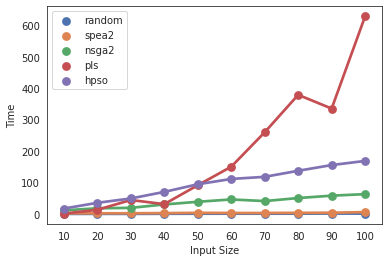

In [19]:
calculate_time_complexity(8, max_input_size = 10)

## Save environment

In [20]:
import dill
dill.dump_session('simulations_diameter.db')